In [2]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mamba_ssm import Mamba

In [3]:
!nvidia-smi

Thu Feb 22 11:06:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   29C    P8              20W / 215W |    835MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
from torch.nn.utils.rnn import pad_sequence

In [16]:
data_dir = "../data/data_preprocessed/crema_d/preprocessed/" 
data_x = np.load(f"{data_dir}crema_d.trill_layer19.train.npy", allow_pickle=True)
data_x.shape

(5144, 12288)

In [17]:
x_train = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_train = pad_sequence(x_train, batch_first=True)
x_train.shape

torch.Size([5144, 12288])

In [18]:
data_x = np.load(f"{data_dir}crema_d.trill_layer19.test.npy", allow_pickle=True)
x_test = [torch.tensor(d.T.real, dtype=torch.float) for d in data_x]
x_test = pad_sequence(x_test, batch_first=True)
x_test.shape

torch.Size([1556, 12288])

In [19]:
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)
print(classnames)

['NEU' 'HAP' 'SAD' 'ANG' 'FEA' 'DIS']


In [20]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5], dtype=int16)

In [21]:
labels = ['ANG', 'NEU', 'SAD']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

torch.Size([2508, 12288])
torch.Size([759, 12288])


In [22]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = x_train[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = x_test[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [23]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [24]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M12_debug
description: FirConv sequential for iemocap
fe:
  n_block: 2
  n_channel:
  - 64
  - 32
  kernel_size:
  - 63
  - 31
  stride:
  - 4
  - 4
  window_k:
  - 5
  - 9
  residual_connection_type: stack
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 48
  pooling: max
  use_context: false
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
         

In [25]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [26]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [27]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.019801980198019802/10 [00:00<05:16, 31.75s/it]

Train Epoch: 1 [0/2508 (0%)]	Loss: 1.062905
Mem before-during-after: 528384 507426304 20809216


  4%|███████▎                                                                                                                                                                       | 0.41584158415841604/10 [00:07<02:49, 17.69s/it]

Train Epoch: 1 [1280/2508 (51%)]	Loss: 1.086708
Mem before-during-after: 20809216 516426752 20809216


 10%|█████████████████▊                                                                                                                                                              | 1.0099009900990106/10 [00:18<02:34, 17.16s/it]


Test Epoch: 1	Accuracy: 322/736 (42%)

Train Epoch: 2 [0/2508 (0%)]	Loss: 1.081177
Mem before-during-after: 20805120 516525056 20809216


 14%|████████████████████████▉                                                                                                                                                       | 1.4158415841584169/10 [00:25<02:30, 17.55s/it]

Train Epoch: 2 [1280/2508 (51%)]	Loss: 1.102694
Mem before-during-after: 20809216 517049344 20809216


 20%|███████████████████████████████████▎                                                                                                                                            | 2.0099009900990112/10 [00:35<02:11, 16.41s/it]


Test Epoch: 2	Accuracy: 362/736 (48%)

Train Epoch: 3 [0/2508 (0%)]	Loss: 1.041145
Mem before-during-after: 20805120 516525056 20809216


 24%|██████████████████████████████████████████▌                                                                                                                                     | 2.4158415841584175/10 [00:42<02:12, 17.43s/it]

Train Epoch: 3 [1280/2508 (51%)]	Loss: 0.984857
Mem before-during-after: 20809216 517049344 20809216


 30%|█████████████████████████████████████████████████████▎                                                                                                                           | 3.009900990099012/10 [00:53<01:59, 17.07s/it]


Test Epoch: 3	Accuracy: 387/736 (51%)

Train Epoch: 4 [0/2508 (0%)]	Loss: 0.971564
Mem before-during-after: 20805120 516525056 20809216


 34%|████████████████████████████████████████████████████████████                                                                                                                    | 3.4158415841584184/10 [01:00<01:58, 17.99s/it]

Train Epoch: 4 [1280/2508 (51%)]	Loss: 1.076349
Mem before-during-after: 20809216 517049344 20809216


 40%|██████████████████████████████████████████████████████████████████████▉                                                                                                          | 4.009900990099013/10 [01:10<01:42, 17.04s/it]


Test Epoch: 4	Accuracy: 405/736 (53%)

Train Epoch: 5 [0/2508 (0%)]	Loss: 0.986976
Mem before-during-after: 20805120 516525056 20809216


 44%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 4.415841584158419/10 [01:17<01:38, 17.67s/it]

Train Epoch: 5 [1280/2508 (51%)]	Loss: 1.010466
Mem before-during-after: 20809216 517049344 20809216


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 5.0099009900990135/10 [01:28<01:24, 16.98s/it]


Test Epoch: 5	Accuracy: 384/736 (51%)

Train Epoch: 6 [0/2508 (0%)]	Loss: 0.956928
Mem before-during-after: 20805120 516525056 20809216


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 5.41584158415842/10 [01:35<01:21, 17.70s/it]

Train Epoch: 6 [1280/2508 (51%)]	Loss: 0.789575
Mem before-during-after: 20809216 517049344 20809216


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6.009900990099014/10 [01:45<01:06, 16.68s/it]


Test Epoch: 6	Accuracy: 450/736 (59%)

Train Epoch: 7 [0/2508 (0%)]	Loss: 0.967709
Mem before-during-after: 20805120 516525056 20809216


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6.415841584158421/10 [01:52<01:02, 17.33s/it]

Train Epoch: 7 [1280/2508 (51%)]	Loss: 0.869985
Mem before-during-after: 20809216 517049344 20809216


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7.009900990099015/10 [02:02<00:49, 16.45s/it]


Test Epoch: 7	Accuracy: 452/736 (60%)

Train Epoch: 8 [0/2508 (0%)]	Loss: 0.843739
Mem before-during-after: 20805120 516525056 20809216


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 7.4158415841584215/10 [02:09<00:44, 17.18s/it]

Train Epoch: 8 [1280/2508 (51%)]	Loss: 0.806310
Mem before-during-after: 20809216 517049344 20809216


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.009900990099014/10 [02:19<00:32, 16.38s/it]


Test Epoch: 8	Accuracy: 478/736 (63%)

Train Epoch: 9 [0/2508 (0%)]	Loss: 0.796209
Mem before-during-after: 20805120 516525056 20809216


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8.415841584158384/10 [02:26<00:27, 17.27s/it]

Train Epoch: 9 [1280/2508 (51%)]	Loss: 0.846215
Mem before-during-after: 20809216 517049344 20809216


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9.009900990098926/10 [02:36<00:16, 16.83s/it]


Test Epoch: 9	Accuracy: 392/736 (52%)

Train Epoch: 10 [0/2508 (0%)]	Loss: 0.811835
Mem before-during-after: 20805120 516525056 20809216


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9.415841584158295/10 [02:43<00:10, 17.27s/it]

Train Epoch: 10 [1280/2508 (51%)]	Loss: 0.970791
Mem before-during-after: 20809216 517049344 20809216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999828/10 [02:53<00:00, 17.36s/it]


Test Epoch: 10	Accuracy: 470/736 (62%)



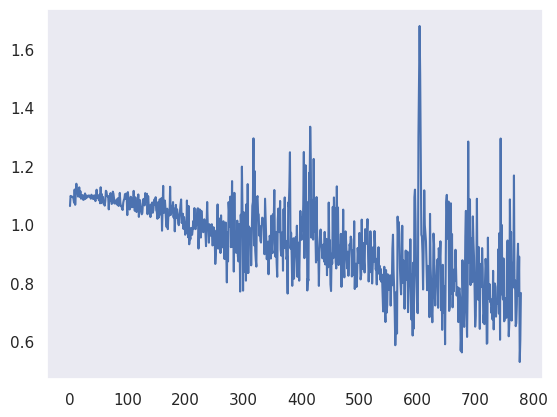

In [28]:
plt.plot(train_losses)

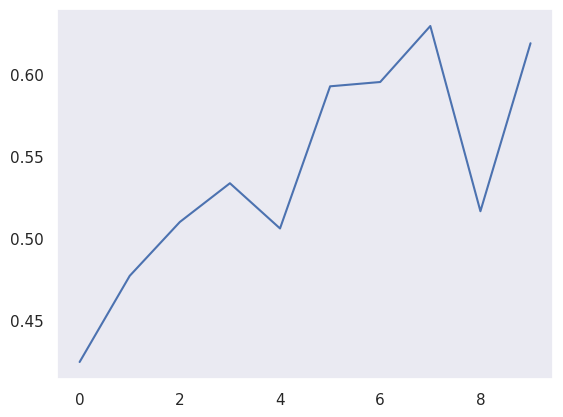

In [29]:
plt.plot(test_accuracy)

In [30]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [31]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 473/736 (0.6427)
{'acc_detail': tensor([0.8411, 0.0407, 0.9611], device='cuda:0'),
 'acc_unweighted': tensor(0.6143, device='cuda:0'),
 'acc_weighted': tensor(0.6427, device='cuda:0'),
 'f1s': tensor(0.5361, device='cuda:0'),
 'f1s_detail': tensor([0.8527, 0.0763, 0.6795], device='cuda:0'),
 'precision_detail': tensor([0.8645, 0.6000, 0.5255], device='cuda:0'),
 'recall_detail': tensor([0.8411, 0.0407, 0.9611], device='cuda:0'),
 'rocauc': tensor([0.9580, 0.7715, 0.8820], device='cuda:0'),
 'uar': tensor(0.6143, device='cuda:0'),
 'wap': tensor(0.6667, device='cuda:0')}


tensor([[217,   2,  39],
        [ 28,   9, 184],
        [  6,   4, 247]], device='cuda:0')

In [32]:
model_path = '../models_cremad3_trill19/cremad_label3_trill19_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [33]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = min(test_accuracy)
model_path_prefix = '../models_cremad3_trill19/cremad_label3_trill19_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:57, 20.35s/it]

Train Epoch: 11 [0/2508 (0%)]	Loss: 0.684040
Mem before-during-after: 19798528 515518464 20855296


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:08<16:12, 19.61s/it]

Train Epoch: 11 [1280/2508 (51%)]	Loss: 0.705458
Mem before-during-after: 20855296 517095424 20855296


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:19<15:31, 19.01s/it]


Test Epoch: 11	Accuracy: 526/736 (69%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_11epoch.pt
Train Epoch: 12 [0/2508 (0%)]	Loss: 0.816887
Mem before-during-after: 20851200 516571136 20855296


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:27<16:02, 19.81s/it]

Train Epoch: 12 [1280/2508 (51%)]	Loss: 0.717171
Mem before-during-after: 20855296 517095424 20855296


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:39<14:52, 18.59s/it]


Test Epoch: 12	Accuracy: 529/736 (70%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_12epoch.pt
Train Epoch: 13 [0/2508 (0%)]	Loss: 0.603083
Mem before-during-after: 20851200 516571136 20855296


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:47<15:08, 19.10s/it]

Train Epoch: 13 [1280/2508 (51%)]	Loss: 0.746389
Mem before-during-after: 20855296 517095424 20855296


  6%|██████████▋                                                                                                                                                                      | 3.009900990099012/50 [00:58<14:25, 18.41s/it]


Test Epoch: 13	Accuracy: 523/736 (69%)

Train Epoch: 14 [0/2508 (0%)]	Loss: 0.603033
Mem before-during-after: 20851200 516571136 20855296


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:06<15:10, 19.56s/it]

Train Epoch: 14 [1280/2508 (51%)]	Loss: 0.660489
Mem before-during-after: 20855296 517095424 20855296


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:17<14:11, 18.52s/it]


Test Epoch: 14	Accuracy: 498/736 (66%)

Train Epoch: 15 [0/2508 (0%)]	Loss: 0.803614
Mem before-during-after: 20851200 516571136 20855296


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:25<14:38, 19.28s/it]

Train Epoch: 15 [1280/2508 (51%)]	Loss: 0.603981
Mem before-during-after: 20855296 517095424 20855296


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:36<13:44, 18.33s/it]


Test Epoch: 15	Accuracy: 533/736 (70%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_15epoch.pt
Train Epoch: 16 [0/2508 (0%)]	Loss: 0.754746
Mem before-during-after: 20851200 516571136 20855296


 11%|███████████████████▎                                                                                                                                                              | 5.41584158415842/50 [01:44<14:40, 19.74s/it]

Train Epoch: 16 [1280/2508 (51%)]	Loss: 1.001774
Mem before-during-after: 20855296 517095424 20855296


 12%|█████████████████████▎                                                                                                                                                           | 6.009900990099014/50 [01:55<13:24, 18.29s/it]


Test Epoch: 16	Accuracy: 456/736 (60%)

Train Epoch: 17 [0/2508 (0%)]	Loss: 0.808119
Mem before-during-after: 20851200 516571136 20855296


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:03<13:46, 18.97s/it]

Train Epoch: 17 [1280/2508 (51%)]	Loss: 0.923120
Mem before-during-after: 20855296 517095424 20855296


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:14<13:08, 18.35s/it]


Test Epoch: 17	Accuracy: 512/736 (67%)

Train Epoch: 18 [0/2508 (0%)]	Loss: 0.785917
Mem before-during-after: 20851200 516571136 20855296


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:22<13:23, 18.87s/it]

Train Epoch: 18 [1280/2508 (51%)]	Loss: 0.938410
Mem before-during-after: 20855296 517095424 20855296


 16%|████████████████████████████▎                                                                                                                                                    | 8.000000000000005/50 [02:33<12:18, 17.59s/it]


Test Epoch: 18	Accuracy: 458/736 (60%)



 16%|████████████████████████████▍                                                                                                                                                    | 8.019801980198023/50 [02:33<13:03, 18.67s/it]

Train Epoch: 19 [0/2508 (0%)]	Loss: 0.653665
Mem before-during-after: 20851200 516571136 20855296


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:40<13:07, 18.94s/it]

Train Epoch: 19 [1280/2508 (51%)]	Loss: 0.998148
Mem before-during-after: 20855296 517095424 20855296


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:52<12:30, 18.30s/it]


Test Epoch: 19	Accuracy: 387/736 (51%)

Train Epoch: 20 [0/2508 (0%)]	Loss: 0.648573
Mem before-during-after: 20851200 516571136 20855296


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [02:59<12:46, 18.88s/it]

Train Epoch: 20 [1280/2508 (51%)]	Loss: 0.773860
Mem before-during-after: 20855296 517095424 20855296


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:11<12:23, 18.59s/it]


Test Epoch: 20	Accuracy: 515/736 (68%)

Train Epoch: 21 [0/2508 (0%)]	Loss: 1.175542
Mem before-during-after: 20851200 516571136 20855296


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:19<12:49, 19.44s/it]

Train Epoch: 21 [1280/2508 (51%)]	Loss: 0.565297
Mem before-during-after: 20855296 517095424 20855296


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:30<12:04, 18.59s/it]


Test Epoch: 21	Accuracy: 527/736 (69%)

Train Epoch: 22 [0/2508 (0%)]	Loss: 0.729043
Mem before-during-after: 20851200 516571136 20855296


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.415841584158118/50 [03:38<12:26, 19.35s/it]

Train Epoch: 22 [1280/2508 (51%)]	Loss: 0.635501
Mem before-during-after: 20855296 517095424 20855296


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:49<11:30, 18.17s/it]


Test Epoch: 22	Accuracy: 526/736 (69%)

Train Epoch: 23 [0/2508 (0%)]	Loss: 0.590920
Mem before-during-after: 20851200 516571136 20855296


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [03:57<12:02, 19.22s/it]

Train Epoch: 23 [1280/2508 (51%)]	Loss: 0.952053
Mem before-during-after: 20855296 517095424 20855296


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 12.999999999999561/50 [04:08<11:09, 18.09s/it]


Test Epoch: 23	Accuracy: 543/736 (72%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_23epoch.pt


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.01980198019758/50 [04:08<11:34, 18.77s/it]

Train Epoch: 24 [0/2508 (0%)]	Loss: 0.709610
Mem before-during-after: 20851200 516571136 20855296


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:16<11:50, 19.43s/it]

Train Epoch: 24 [1280/2508 (51%)]	Loss: 0.892212
Mem before-during-after: 20855296 517095424 20855296


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:27<11:00, 18.37s/it]


Test Epoch: 24	Accuracy: 480/736 (63%)

Train Epoch: 25 [0/2508 (0%)]	Loss: 0.681590
Mem before-during-after: 20851200 516571136 20855296


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:35<11:16, 19.01s/it]

Train Epoch: 25 [1280/2508 (51%)]	Loss: 0.740631
Mem before-during-after: 20855296 517095424 20855296


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:46<10:41, 18.35s/it]


Test Epoch: 25	Accuracy: 549/736 (72%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_25epoch.pt
Train Epoch: 26 [0/2508 (0%)]	Loss: 0.632755
Mem before-during-after: 20851200 516571136 20855296


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [04:54<11:05, 19.25s/it]

Train Epoch: 26 [1280/2508 (51%)]	Loss: 0.829764
Mem before-during-after: 20855296 517095424 20855296


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [05:05<10:18, 18.19s/it]


Test Epoch: 26	Accuracy: 482/736 (64%)

Train Epoch: 27 [0/2508 (0%)]	Loss: 0.596173
Mem before-during-after: 20851200 516571136 20855296


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:13<10:40, 19.06s/it]

Train Epoch: 27 [1280/2508 (51%)]	Loss: 0.699513
Mem before-during-after: 20855296 517095424 20855296


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:24<10:05, 18.36s/it]


Test Epoch: 27	Accuracy: 559/736 (74%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_27epoch.pt
Train Epoch: 28 [0/2508 (0%)]	Loss: 0.782162
Mem before-during-after: 20851200 516571136 20855296


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:32<10:18, 18.98s/it]

Train Epoch: 28 [1280/2508 (51%)]	Loss: 0.681288
Mem before-during-after: 20855296 517095424 20855296


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:43<09:47, 18.36s/it]


Test Epoch: 28	Accuracy: 550/736 (72%)

Train Epoch: 29 [0/2508 (0%)]	Loss: 0.815246
Mem before-during-after: 20851200 516571136 20855296


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [05:51<10:00, 19.02s/it]

Train Epoch: 29 [1280/2508 (51%)]	Loss: 0.528354
Mem before-during-after: 20855296 517095424 20855296


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [06:02<09:25, 18.23s/it]


Test Epoch: 29	Accuracy: 547/736 (72%)

Train Epoch: 30 [0/2508 (0%)]	Loss: 0.712200
Mem before-during-after: 20851200 516571136 20855296


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:09<09:43, 19.07s/it]

Train Epoch: 30 [1280/2508 (51%)]	Loss: 0.973438
Mem before-during-after: 20855296 517095424 20855296


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.00990099009795/50 [06:21<09:08, 18.28s/it]


Test Epoch: 30	Accuracy: 499/736 (66%)

Train Epoch: 31 [0/2508 (0%)]	Loss: 0.667868
Mem before-during-after: 20851200 516571136 20855296


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:28<09:31, 19.32s/it]

Train Epoch: 31 [1280/2508 (51%)]	Loss: 0.716607
Mem before-during-after: 20855296 517095424 20855296


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:40<08:58, 18.56s/it]


Test Epoch: 31	Accuracy: 562/736 (74%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_31epoch.pt
Train Epoch: 32 [0/2508 (0%)]	Loss: 0.809253
Mem before-during-after: 20851200 516571136 20855296


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [06:47<09:02, 18.99s/it]

Train Epoch: 32 [1280/2508 (51%)]	Loss: 0.657821
Mem before-during-after: 20855296 517095424 20855296


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [06:59<08:33, 18.35s/it]


Test Epoch: 32	Accuracy: 561/736 (74%)

Train Epoch: 33 [0/2508 (0%)]	Loss: 0.586696
Mem before-during-after: 20851200 516571136 20855296


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [07:06<08:54, 19.38s/it]

Train Epoch: 33 [1280/2508 (51%)]	Loss: 0.534895
Mem before-during-after: 20855296 517095424 20855296


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:18<08:22, 18.61s/it]


Test Epoch: 33	Accuracy: 544/736 (72%)

Train Epoch: 34 [0/2508 (0%)]	Loss: 0.768547
Mem before-during-after: 20851200 516571136 20855296


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:26<08:24, 18.98s/it]

Train Epoch: 34 [1280/2508 (51%)]	Loss: 0.647221
Mem before-during-after: 20855296 517095424 20855296


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:37<07:59, 18.44s/it]


Test Epoch: 34	Accuracy: 563/736 (74%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_34epoch.pt
Train Epoch: 35 [0/2508 (0%)]	Loss: 0.605059
Mem before-during-after: 20851200 516571136 20855296


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [07:44<08:06, 19.00s/it]

Train Epoch: 35 [1280/2508 (51%)]	Loss: 0.582704
Mem before-during-after: 20855296 517095424 20855296


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [07:56<07:36, 18.28s/it]


Test Epoch: 35	Accuracy: 518/736 (68%)

Train Epoch: 36 [0/2508 (0%)]	Loss: 0.767543
Mem before-during-after: 20851200 516571136 20855296


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [08:03<07:48, 19.06s/it]

Train Epoch: 36 [1280/2508 (51%)]	Loss: 0.385332
Mem before-during-after: 20855296 517095424 20855296


 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.009900990097417/50 [08:14<07:20, 18.38s/it]


Test Epoch: 36	Accuracy: 475/736 (63%)

Train Epoch: 37 [0/2508 (0%)]	Loss: 0.823699
Mem before-during-after: 20851200 516571136 20855296


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:22<07:32, 19.20s/it]

Train Epoch: 37 [1280/2508 (51%)]	Loss: 0.700195
Mem before-during-after: 20855296 517095424 20855296


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:33<07:01, 18.32s/it]


Test Epoch: 37	Accuracy: 517/736 (68%)

Train Epoch: 38 [0/2508 (0%)]	Loss: 0.425664
Mem before-during-after: 20851200 516571136 20855296


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [08:41<07:13, 19.19s/it]

Train Epoch: 38 [1280/2508 (51%)]	Loss: 0.783284
Mem before-during-after: 20855296 517095424 20855296


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [08:53<06:45, 18.44s/it]


Test Epoch: 38	Accuracy: 536/736 (71%)

Train Epoch: 39 [0/2508 (0%)]	Loss: 0.438576
Mem before-during-after: 20851200 516571136 20855296


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [09:00<06:58, 19.38s/it]

Train Epoch: 39 [1280/2508 (51%)]	Loss: 0.761944
Mem before-during-after: 20855296 517095424 20855296


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 28.999999999998142/50 [09:11<06:14, 17.86s/it]


Test Epoch: 39	Accuracy: 567/736 (75%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_39epoch.pt


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.01980198019616/50 [09:12<06:35, 18.83s/it]

Train Epoch: 40 [0/2508 (0%)]	Loss: 0.630541
Mem before-during-after: 20851200 516571136 20855296


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:20<06:42, 19.56s/it]

Train Epoch: 40 [1280/2508 (51%)]	Loss: 0.648640
Mem before-during-after: 20855296 517095424 20855296


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:31<06:07, 18.40s/it]


Test Epoch: 40	Accuracy: 523/736 (69%)

Train Epoch: 41 [0/2508 (0%)]	Loss: 0.809993
Mem before-during-after: 20851200 516571136 20855296


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:39<06:13, 19.05s/it]

Train Epoch: 41 [1280/2508 (51%)]	Loss: 0.740228
Mem before-during-after: 20855296 517095424 20855296


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.009900990096973/50 [09:50<05:48, 18.36s/it]


Test Epoch: 41	Accuracy: 540/736 (71%)

Train Epoch: 42 [0/2508 (0%)]	Loss: 0.692104
Mem before-during-after: 20851200 516571136 20855296


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [09:58<05:54, 19.09s/it]

Train Epoch: 42 [1280/2508 (51%)]	Loss: 0.537594
Mem before-during-after: 20855296 517095424 20855296


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [10:09<05:30, 18.39s/it]


Test Epoch: 42	Accuracy: 592/736 (78%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_42epoch.pt
Train Epoch: 43 [0/2508 (0%)]	Loss: 0.512906
Mem before-during-after: 20851200 516571136 20855296


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:16<05:39, 19.33s/it]

Train Epoch: 43 [1280/2508 (51%)]	Loss: 0.643844
Mem before-during-after: 20855296 517095424 20855296


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 33.00990099009716/50 [10:28<05:10, 18.27s/it]


Test Epoch: 43	Accuracy: 581/736 (77%)

Train Epoch: 44 [0/2508 (0%)]	Loss: 0.580131
Mem before-during-after: 20851200 516571136 20855296


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:35<05:16, 19.06s/it]

Train Epoch: 44 [1280/2508 (51%)]	Loss: 0.439794
Mem before-during-after: 20855296 517095424 20855296


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [10:47<04:55, 18.47s/it]


Test Epoch: 44	Accuracy: 570/736 (75%)

Train Epoch: 45 [0/2508 (0%)]	Loss: 0.700422
Mem before-during-after: 20851200 516571136 20855296


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [10:55<05:00, 19.31s/it]

Train Epoch: 45 [1280/2508 (51%)]	Loss: 0.570935
Mem before-during-after: 20855296 517095424 20855296


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [11:06<04:36, 18.42s/it]


Test Epoch: 45	Accuracy: 573/736 (75%)

Train Epoch: 46 [0/2508 (0%)]	Loss: 0.424998
Mem before-during-after: 20851200 516571136 20855296


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [11:14<04:45, 19.59s/it]

Train Epoch: 46 [1280/2508 (51%)]	Loss: 0.739717
Mem before-during-after: 20855296 517095424 20855296


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 36.00990099009797/50 [11:25<04:21, 18.72s/it]


Test Epoch: 46	Accuracy: 576/736 (76%)

Train Epoch: 47 [0/2508 (0%)]	Loss: 0.845366
Mem before-during-after: 20851200 516571136 20855296


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:33<04:25, 19.58s/it]

Train Epoch: 47 [1280/2508 (51%)]	Loss: 0.589197
Mem before-during-after: 20855296 517095424 20855296


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 37.00990099009824/50 [11:44<04:01, 18.56s/it]


Test Epoch: 47	Accuracy: 563/736 (74%)

Train Epoch: 48 [0/2508 (0%)]	Loss: 0.325586
Mem before-during-after: 20851200 516571136 20855296


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [11:52<04:03, 19.36s/it]

Train Epoch: 48 [1280/2508 (51%)]	Loss: 0.613804
Mem before-during-after: 20855296 517095424 20855296


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [12:03<03:37, 18.13s/it]


Test Epoch: 48	Accuracy: 587/736 (77%)

Train Epoch: 49 [0/2508 (0%)]	Loss: 0.386953
Mem before-during-after: 20851200 516571136 20855296


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [12:11<03:39, 18.96s/it]

Train Epoch: 49 [1280/2508 (51%)]	Loss: 0.553874
Mem before-during-after: 20855296 517095424 20855296


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 39.00990099009878/50 [12:22<03:25, 18.70s/it]


Test Epoch: 49	Accuracy: 587/736 (77%)

Train Epoch: 50 [0/2508 (0%)]	Loss: 0.713811
Mem before-during-after: 20851200 516571136 20855296


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:30<03:26, 19.52s/it]

Train Epoch: 50 [1280/2508 (51%)]	Loss: 0.837395
Mem before-during-after: 20855296 517095424 20855296


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [12:42<03:06, 18.67s/it]


Test Epoch: 50	Accuracy: 588/736 (77%)

Train Epoch: 51 [0/2508 (0%)]	Loss: 0.574733
Mem before-during-after: 20851200 516571136 20855296


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [12:50<03:05, 19.32s/it]

Train Epoch: 51 [1280/2508 (51%)]	Loss: 0.807844
Mem before-during-after: 20855296 517095424 20855296


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [13:01<02:48, 18.75s/it]


Test Epoch: 51	Accuracy: 489/736 (64%)

Train Epoch: 52 [0/2508 (0%)]	Loss: 0.750791
Mem before-during-after: 20851200 516571136 20855296


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [13:09<02:46, 19.37s/it]

Train Epoch: 52 [1280/2508 (51%)]	Loss: 0.776367
Mem before-during-after: 20855296 517095424 20855296


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 42.000000000000576/50 [13:20<02:26, 18.36s/it]


Test Epoch: 52	Accuracy: 583/736 (77%)

Train Epoch: 53 [0/2508 (0%)]	Loss: 0.692820
Mem before-during-after: 20851200 516571136 20855296


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:28<02:25, 19.25s/it]

Train Epoch: 53 [1280/2508 (51%)]	Loss: 0.429368
Mem before-during-after: 20855296 517095424 20855296


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [13:39<02:11, 18.85s/it]


Test Epoch: 53	Accuracy: 595/736 (78%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_53epoch.pt
Train Epoch: 54 [0/2508 (0%)]	Loss: 0.508572
Mem before-during-after: 20851200 516571136 20855296


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [13:47<02:08, 19.53s/it]

Train Epoch: 54 [1280/2508 (51%)]	Loss: 0.453085
Mem before-during-after: 20855296 517095424 20855296


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [13:59<01:52, 18.81s/it]


Test Epoch: 54	Accuracy: 580/736 (76%)

Train Epoch: 55 [0/2508 (0%)]	Loss: 0.610102
Mem before-during-after: 20851200 516571136 20855296


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 44.415841584159644/50 [14:07<01:48, 19.51s/it]

Train Epoch: 55 [1280/2508 (51%)]	Loss: 0.469798
Mem before-during-after: 20855296 517095424 20855296


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 45.0099009901004/50 [14:18<01:30, 18.14s/it]


Test Epoch: 55	Accuracy: 532/736 (70%)

Train Epoch: 56 [0/2508 (0%)]	Loss: 0.375323
Mem before-during-after: 20851200 516571136 20855296


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:26<01:27, 19.04s/it]

Train Epoch: 56 [1280/2508 (51%)]	Loss: 0.712992
Mem before-during-after: 20855296 517095424 20855296


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [14:37<01:12, 18.21s/it]


Test Epoch: 56	Accuracy: 587/736 (77%)

Train Epoch: 57 [0/2508 (0%)]	Loss: 0.367245
Mem before-during-after: 20851200 516571136 20855296


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [14:45<01:07, 18.89s/it]

Train Epoch: 57 [1280/2508 (51%)]	Loss: 0.615966
Mem before-during-after: 20855296 517095424 20855296


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [14:56<00:54, 18.35s/it]


Test Epoch: 57	Accuracy: 584/736 (77%)

Train Epoch: 58 [0/2508 (0%)]	Loss: 0.544019
Mem before-during-after: 20851200 516571136 20855296


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [15:03<00:49, 19.05s/it]

Train Epoch: 58 [1280/2508 (51%)]	Loss: 0.445097
Mem before-during-after: 20855296 517095424 20855296


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [15:14<00:36, 18.28s/it]


Test Epoch: 58	Accuracy: 563/736 (74%)

Train Epoch: 59 [0/2508 (0%)]	Loss: 0.571065
Mem before-during-after: 20851200 516571136 20855296


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [15:22<00:30, 19.15s/it]

Train Epoch: 59 [1280/2508 (51%)]	Loss: 0.369710
Mem before-during-after: 20855296 517095424 20855296


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [15:33<00:18, 18.32s/it]


Test Epoch: 59	Accuracy: 588/736 (77%)

Train Epoch: 60 [0/2508 (0%)]	Loss: 0.487568
Mem before-during-after: 20851200 516571136 20855296


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.415841584160994/50 [15:41<00:11, 19.03s/it]

Train Epoch: 60 [1280/2508 (51%)]	Loss: 0.577677
Mem before-during-after: 20855296 517095424 20855296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99009900990372/50 [15:52<00:00, 17.60s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [15:52<00:00, 19.05s/it]


Test Epoch: 60	Accuracy: 589/736 (78%)



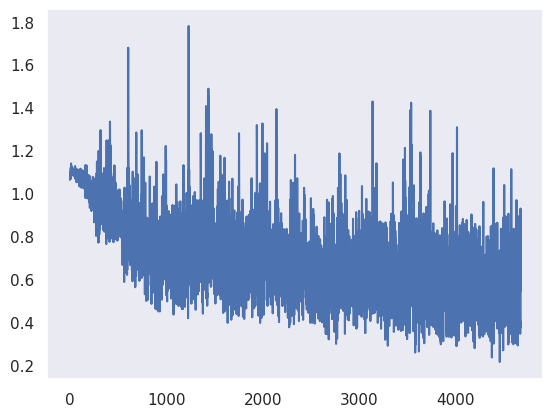

In [34]:
plt.plot(train_losses)

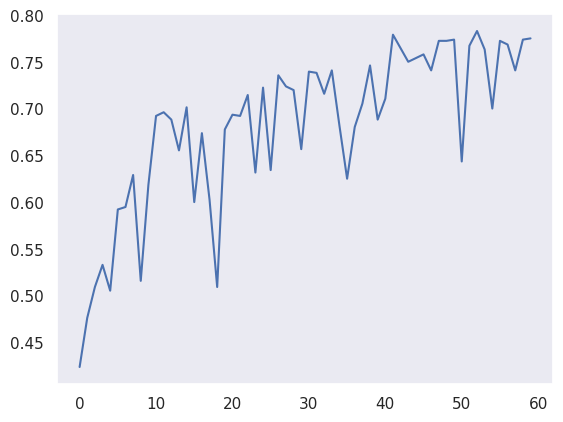

In [35]:
plt.plot(test_accuracy)

In [36]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 587/736 (0.7976)
{'acc_detail': tensor([0.8256, 0.8864, 0.6938], device='cuda:0'),
 'acc_unweighted': tensor(0.8019, device='cuda:0'),
 'acc_weighted': tensor(0.7976, device='cuda:0'),
 'f1s': tensor(0.8002, device='cuda:0'),
 'f1s_detail': tensor([0.8894, 0.7263, 0.7851], device='cuda:0'),
 'precision_detail': tensor([0.9638, 0.6151, 0.9040], device='cuda:0'),
 'recall_detail': tensor([0.8256, 0.8864, 0.6938], device='cuda:0'),
 'rocauc': tensor([0.9801, 0.8908, 0.9363], device='cuda:0'),
 'uar': tensor(0.8019, device='cuda:0'),
 'wap': tensor(0.8386, device='cuda:0')}


tensor([[213,  45,   0],
        [  6, 195,  19],
        [  2,  77, 179]], device='cuda:0')

In [37]:
model.to("cpu")

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [38]:
best_epoch = 53
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 594/736 (0.8071)
{'acc_detail': tensor([0.9344, 0.7511, 0.7266], device='cuda:0'),
 'acc_unweighted': tensor(0.8040, device='cuda:0'),
 'acc_weighted': tensor(0.8071, device='cuda:0'),
 'f1s': tensor(0.8023, device='cuda:0'),
 'f1s_detail': tensor([0.9098, 0.7140, 0.7832], device='cuda:0'),
 'precision_detail': tensor([0.8864, 0.6803, 0.8493], device='cuda:0'),
 'recall_detail': tensor([0.9344, 0.7511, 0.7266], device='cuda:0'),
 'rocauc': tensor([0.9812, 0.8911, 0.9352], device='cuda:0'),
 'uar': tensor(0.8040, device='cuda:0'),
 'wap': tensor(0.8116, device='cuda:0')}


tensor([[242,  17,   0],
        [ 22, 166,  33],
        [  9,  61, 186]], device='cuda:0')

In [39]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [40]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/40 [00:00<12:54, 19.37s/it]

Train Epoch: 61 [0/2508 (0%)]	Loss: 0.349770
Mem before-during-after: 21550080 517270016 22606336


  1%|█▊                                                                                                                                                                             | 0.41584158415841604/40 [00:08<13:04, 19.82s/it]

Train Epoch: 61 [1280/2508 (51%)]	Loss: 0.378041
Mem before-during-after: 22606336 518846464 22606336


  3%|████▍                                                                                                                                                                           | 1.0099009900990106/40 [00:19<12:11, 18.77s/it]


Test Epoch: 61	Accuracy: 584/736 (77%)

Train Epoch: 62 [0/2508 (0%)]	Loss: 0.435907
Mem before-during-after: 22602240 518322176 22606336


  4%|██████▏                                                                                                                                                                         | 1.4158415841584169/40 [00:27<12:33, 19.53s/it]

Train Epoch: 62 [1280/2508 (51%)]	Loss: 0.730063
Mem before-during-after: 22606336 518846464 22606336


  5%|████████▊                                                                                                                                                                       | 2.0099009900990112/40 [00:39<11:51, 18.72s/it]


Test Epoch: 62	Accuracy: 595/736 (78%)

Train Epoch: 63 [0/2508 (0%)]	Loss: 0.521424
Mem before-during-after: 22602240 518322176 22606336


  6%|██████████▋                                                                                                                                                                     | 2.4158415841584175/40 [00:46<12:02, 19.22s/it]

Train Epoch: 63 [1280/2508 (51%)]	Loss: 0.883144
Mem before-during-after: 22606336 518846464 22606336


  8%|█████████████▎                                                                                                                                                                   | 3.009900990099012/40 [00:58<11:29, 18.63s/it]


Test Epoch: 63	Accuracy: 600/736 (79%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_63epoch.pt
Train Epoch: 64 [0/2508 (0%)]	Loss: 0.423924
Mem before-during-after: 22602240 518322176 22606336


  9%|███████████████                                                                                                                                                                 | 3.4158415841584184/40 [01:06<11:45, 19.27s/it]

Train Epoch: 64 [1280/2508 (51%)]	Loss: 0.598141
Mem before-during-after: 22606336 518846464 22606336


 10%|█████████████████▋                                                                                                                                                               | 4.009900990099013/40 [01:17<11:10, 18.63s/it]


Test Epoch: 64	Accuracy: 601/736 (79%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_64epoch.pt
Train Epoch: 65 [0/2508 (0%)]	Loss: 0.735602
Mem before-during-after: 22602240 518322176 22606336


 11%|███████████████████▌                                                                                                                                                             | 4.415841584158419/40 [01:25<11:42, 19.74s/it]

Train Epoch: 65 [1280/2508 (51%)]	Loss: 0.737664
Mem before-during-after: 22606336 518846464 22606336


 13%|██████████████████████                                                                                                                                                          | 5.0099009900990135/40 [01:36<11:06, 19.05s/it]


Test Epoch: 65	Accuracy: 596/736 (79%)

Train Epoch: 66 [0/2508 (0%)]	Loss: 0.478171
Mem before-during-after: 22602240 518322176 22606336


 14%|████████████████████████                                                                                                                                                          | 5.41584158415842/40 [01:44<11:39, 20.24s/it]

Train Epoch: 66 [1280/2508 (51%)]	Loss: 0.249482
Mem before-during-after: 22606336 518846464 22606336


 15%|██████████████████████████▌                                                                                                                                                      | 6.009900990099014/40 [01:56<10:45, 19.00s/it]


Test Epoch: 66	Accuracy: 584/736 (77%)

Train Epoch: 67 [0/2508 (0%)]	Loss: 0.419726
Mem before-during-after: 22602240 518322176 22606336


 16%|████████████████████████████▍                                                                                                                                                    | 6.415841584158421/40 [02:04<11:00, 19.68s/it]

Train Epoch: 67 [1280/2508 (51%)]	Loss: 0.461117
Mem before-during-after: 22606336 518846464 22606336


 18%|███████████████████████████████                                                                                                                                                  | 7.009900990099015/40 [02:16<10:26, 18.98s/it]


Test Epoch: 67	Accuracy: 590/736 (78%)

Train Epoch: 68 [0/2508 (0%)]	Loss: 0.497329
Mem before-during-after: 22602240 518322176 22606336


 19%|████████████████████████████████▊                                                                                                                                                | 7.405940594059412/40 [02:23<10:51, 20.00s/it]

Train Epoch: 68 [1280/2508 (51%)]	Loss: 0.499746
Mem before-during-after: 22606336 518846464 22606336


 20%|███████████████████████████████████▍                                                                                                                                             | 8.009900990099014/40 [02:35<10:05, 18.94s/it]


Test Epoch: 68	Accuracy: 572/736 (75%)

Train Epoch: 69 [0/2508 (0%)]	Loss: 0.646085
Mem before-during-after: 22602240 518322176 22606336


 21%|█████████████████████████████████████▏                                                                                                                                           | 8.415841584158384/40 [02:43<10:20, 19.64s/it]

Train Epoch: 69 [1280/2508 (51%)]	Loss: 0.556478
Mem before-during-after: 22606336 518846464 22606336


 23%|███████████████████████████████████████▊                                                                                                                                         | 9.009900990098926/40 [02:55<09:47, 18.95s/it]


Test Epoch: 69	Accuracy: 595/736 (78%)

Train Epoch: 70 [0/2508 (0%)]	Loss: 0.531871
Mem before-during-after: 22602240 518322176 22606336


 24%|█████████████████████████████████████████▋                                                                                                                                       | 9.415841584158295/40 [03:03<10:06, 19.83s/it]

Train Epoch: 70 [1280/2508 (51%)]	Loss: 0.444196
Mem before-during-after: 22606336 518846464 22606336


 25%|████████████████████████████████████████████▏                                                                                                                                    | 9.999999999999828/40 [03:14<09:13, 18.45s/it]


Test Epoch: 70	Accuracy: 602/736 (79%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_70epoch.pt


 25%|████████████████████████████████████████████                                                                                                                                    | 10.019801980197846/40 [03:14<09:27, 18.94s/it]

Train Epoch: 71 [0/2508 (0%)]	Loss: 0.267059
Mem before-during-after: 22602240 518322176 22606336


 26%|█████████████████████████████████████████████▊                                                                                                                                  | 10.405940594059198/40 [03:22<09:53, 20.05s/it]

Train Epoch: 71 [1280/2508 (51%)]	Loss: 0.378863
Mem before-during-after: 22606336 518846464 22606336


 28%|████████████████████████████████████████████████▍                                                                                                                               | 11.009900990098748/40 [03:34<09:17, 19.23s/it]


Test Epoch: 71	Accuracy: 585/736 (77%)

Train Epoch: 72 [0/2508 (0%)]	Loss: 0.562753
Mem before-during-after: 22602240 518322176 22606336


 29%|██████████████████████████████████████████████████▏                                                                                                                             | 11.415841584158118/40 [03:42<09:24, 19.76s/it]

Train Epoch: 72 [1280/2508 (51%)]	Loss: 0.550089
Mem before-during-after: 22606336 518846464 22606336


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 12.009900990098659/40 [03:53<08:52, 19.01s/it]


Test Epoch: 72	Accuracy: 572/736 (75%)

Train Epoch: 73 [0/2508 (0%)]	Loss: 0.599733
Mem before-during-after: 22602240 518322176 22606336


 31%|██████████████████████████████████████████████████████▋                                                                                                                         | 12.415841584158029/40 [04:01<08:49, 19.21s/it]

Train Epoch: 73 [1280/2508 (51%)]	Loss: 0.498409
Mem before-during-after: 22606336 518846464 22606336


 33%|█████████████████████████████████████████████████████████▌                                                                                                                       | 13.00990099009857/40 [04:12<08:17, 18.44s/it]


Test Epoch: 73	Accuracy: 573/736 (75%)

Train Epoch: 74 [0/2508 (0%)]	Loss: 0.487875
Mem before-during-after: 22602240 518322176 22606336


 34%|███████████████████████████████████████████████████████████▎                                                                                                                     | 13.41584158415794/40 [04:20<08:29, 19.16s/it]

Train Epoch: 74 [1280/2508 (51%)]	Loss: 0.621673
Mem before-during-after: 22606336 518846464 22606336


 35%|█████████████████████████████████████████████████████████████▋                                                                                                                  | 14.009900990098481/40 [04:31<07:59, 18.46s/it]


Test Epoch: 74	Accuracy: 594/736 (78%)

Train Epoch: 75 [0/2508 (0%)]	Loss: 0.545151
Mem before-during-after: 22602240 518322176 22606336


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 14.415841584157851/40 [04:39<08:21, 19.61s/it]

Train Epoch: 75 [1280/2508 (51%)]	Loss: 0.399788
Mem before-during-after: 22606336 518846464 22606336


 38%|██████████████████████████████████████████████████████████████████                                                                                                              | 15.009900990098393/40 [04:51<07:46, 18.67s/it]


Test Epoch: 75	Accuracy: 589/736 (78%)

Train Epoch: 76 [0/2508 (0%)]	Loss: 0.580618
Mem before-during-after: 22602240 518322176 22606336


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                            | 15.415841584157763/40 [04:59<08:01, 19.59s/it]

Train Epoch: 76 [1280/2508 (51%)]	Loss: 0.448140
Mem before-during-after: 22606336 518846464 22606336


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 16.009900990098306/40 [05:10<07:25, 18.56s/it]


Test Epoch: 76	Accuracy: 593/736 (78%)

Train Epoch: 77 [0/2508 (0%)]	Loss: 0.625446
Mem before-during-after: 22602240 518322176 22606336


 41%|████████████████████████████████████████████████████████████████████████▏                                                                                                       | 16.415841584157675/40 [05:18<07:40, 19.52s/it]

Train Epoch: 77 [1280/2508 (51%)]	Loss: 0.474596
Mem before-during-after: 22606336 518846464 22606336


 43%|██████████████████████████████████████████████████████████████████████████▊                                                                                                     | 17.009900990098217/40 [05:29<07:12, 18.82s/it]


Test Epoch: 77	Accuracy: 608/736 (80%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_77epoch.pt
Train Epoch: 78 [0/2508 (0%)]	Loss: 0.610460
Mem before-during-after: 22602240 518322176 22606336


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 17.415841584157587/40 [05:37<07:19, 19.47s/it]

Train Epoch: 78 [1280/2508 (51%)]	Loss: 0.496654
Mem before-during-after: 22606336 518846464 22606336


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 18.009900990098128/40 [05:48<06:55, 18.87s/it]


Test Epoch: 78	Accuracy: 574/736 (76%)

Train Epoch: 79 [0/2508 (0%)]	Loss: 0.457878
Mem before-during-after: 22602240 518322176 22606336


 46%|█████████████████████████████████████████████████████████████████████████████████                                                                                               | 18.415841584157498/40 [05:57<07:10, 19.96s/it]

Train Epoch: 79 [1280/2508 (51%)]	Loss: 0.404763
Mem before-during-after: 22606336 518846464 22606336


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                             | 19.00990099009804/40 [06:08<06:37, 18.95s/it]


Test Epoch: 79	Accuracy: 586/736 (77%)

Train Epoch: 80 [0/2508 (0%)]	Loss: 0.329198
Mem before-during-after: 22602240 518322176 22606336


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 19.41584158415741/40 [06:16<06:45, 19.71s/it]

Train Epoch: 80 [1280/2508 (51%)]	Loss: 0.400079
Mem before-during-after: 22606336 518846464 22606336


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 20.00990099009795/40 [06:28<06:21, 19.06s/it]


Test Epoch: 80	Accuracy: 597/736 (79%)

Train Epoch: 81 [0/2508 (0%)]	Loss: 0.562299
Mem before-during-after: 22602240 518322176 22606336


 51%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 20.41584158415732/40 [06:36<06:26, 19.74s/it]

Train Epoch: 81 [1280/2508 (51%)]	Loss: 0.457556
Mem before-during-after: 22606336 518846464 22606336


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 21.00990099009786/40 [06:47<06:02, 19.07s/it]


Test Epoch: 81	Accuracy: 597/736 (79%)

Train Epoch: 82 [0/2508 (0%)]	Loss: 0.572279
Mem before-during-after: 22602240 518322176 22606336


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 21.41584158415723/40 [06:55<06:10, 19.93s/it]

Train Epoch: 82 [1280/2508 (51%)]	Loss: 0.622396
Mem before-during-after: 22606336 518846464 22606336


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 22.009900990097773/40 [07:07<05:37, 18.74s/it]


Test Epoch: 82	Accuracy: 557/736 (73%)

Train Epoch: 83 [0/2508 (0%)]	Loss: 0.623227
Mem before-during-after: 22602240 518322176 22606336


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 22.415841584157143/40 [07:15<05:47, 19.79s/it]

Train Epoch: 83 [1280/2508 (51%)]	Loss: 0.387816
Mem before-during-after: 22606336 518846464 22606336


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 23.009900990097684/40 [07:26<05:23, 19.04s/it]


Test Epoch: 83	Accuracy: 593/736 (78%)

Train Epoch: 84 [0/2508 (0%)]	Loss: 0.427238
Mem before-during-after: 22602240 518322176 22606336


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 23.415841584157054/40 [07:34<05:26, 19.69s/it]

Train Epoch: 84 [1280/2508 (51%)]	Loss: 0.457575
Mem before-during-after: 22606336 518846464 22606336


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 24.009900990097595/40 [07:46<05:02, 18.89s/it]


Test Epoch: 84	Accuracy: 586/736 (77%)

Train Epoch: 85 [0/2508 (0%)]	Loss: 0.596191
Mem before-during-after: 22602240 518322176 22606336


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 24.415841584156965/40 [07:54<05:06, 19.68s/it]

Train Epoch: 85 [1280/2508 (51%)]	Loss: 0.653206
Mem before-during-after: 22606336 518846464 22606336


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 25.009900990097506/40 [08:05<04:44, 19.01s/it]


Test Epoch: 85	Accuracy: 597/736 (79%)

Train Epoch: 86 [0/2508 (0%)]	Loss: 0.537505
Mem before-during-after: 22602240 518322176 22606336


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 25.415841584156876/40 [08:13<04:43, 19.45s/it]

Train Epoch: 86 [1280/2508 (51%)]	Loss: 0.457264
Mem before-during-after: 22606336 518846464 22606336


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 26.009900990097417/40 [08:24<04:19, 18.53s/it]


Test Epoch: 86	Accuracy: 605/736 (80%)

Train Epoch: 87 [0/2508 (0%)]	Loss: 0.243710
Mem before-during-after: 22602240 518322176 22606336


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 26.415841584156787/40 [08:32<04:28, 19.79s/it]

Train Epoch: 87 [1280/2508 (51%)]	Loss: 0.673963
Mem before-during-after: 22606336 518846464 22606336


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 27.00990099009733/40 [08:43<04:00, 18.50s/it]


Test Epoch: 87	Accuracy: 597/736 (79%)

Train Epoch: 88 [0/2508 (0%)]	Loss: 0.531376
Mem before-during-after: 22602240 518322176 22606336


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27.4158415841567/40 [08:51<04:06, 19.58s/it]

Train Epoch: 88 [1280/2508 (51%)]	Loss: 0.438975
Mem before-during-after: 22606336 518846464 22606336


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 28.00990099009724/40 [09:02<03:42, 18.56s/it]


Test Epoch: 88	Accuracy: 593/736 (78%)

Train Epoch: 89 [0/2508 (0%)]	Loss: 0.406176
Mem before-during-after: 22602240 518322176 22606336


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28.41584158415661/40 [09:10<03:44, 19.37s/it]

Train Epoch: 89 [1280/2508 (51%)]	Loss: 0.465137
Mem before-during-after: 22606336 518846464 22606336


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 29.00990099009715/40 [09:22<03:28, 18.94s/it]


Test Epoch: 89	Accuracy: 595/736 (78%)

Train Epoch: 90 [0/2508 (0%)]	Loss: 0.312075
Mem before-during-after: 22602240 518322176 22606336


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29.41584158415652/40 [09:30<03:24, 19.37s/it]

Train Epoch: 90 [1280/2508 (51%)]	Loss: 0.555182
Mem before-during-after: 22606336 518846464 22606336


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30.009900990097062/40 [09:41<03:06, 18.62s/it]


Test Epoch: 90	Accuracy: 570/736 (75%)

Train Epoch: 91 [0/2508 (0%)]	Loss: 0.587919
Mem before-during-after: 22602240 518322176 22606336


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30.415841584156432/40 [09:49<03:05, 19.34s/it]

Train Epoch: 91 [1280/2508 (51%)]	Loss: 0.475626
Mem before-during-after: 22606336 518846464 22606336


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31.009900990096973/40 [10:00<02:46, 18.54s/it]


Test Epoch: 91	Accuracy: 576/736 (76%)

Train Epoch: 92 [0/2508 (0%)]	Loss: 0.410209
Mem before-during-after: 22602240 518322176 22606336


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 31.415841584156343/40 [10:08<02:45, 19.28s/it]

Train Epoch: 92 [1280/2508 (51%)]	Loss: 0.481271
Mem before-during-after: 22606336 518846464 22606336


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 32.00990099009689/40 [10:19<02:29, 18.67s/it]


Test Epoch: 92	Accuracy: 604/736 (80%)

Train Epoch: 93 [0/2508 (0%)]	Loss: 0.616416
Mem before-during-after: 22602240 518322176 22606336


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 32.415841584156404/40 [10:27<02:26, 19.35s/it]

Train Epoch: 93 [1280/2508 (51%)]	Loss: 0.489229
Mem before-during-after: 22606336 518846464 22606336


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33.00990099009716/40 [10:38<02:09, 18.55s/it]


Test Epoch: 93	Accuracy: 553/736 (73%)

Train Epoch: 94 [0/2508 (0%)]	Loss: 0.572075
Mem before-during-after: 22602240 518322176 22606336


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 33.415841584156674/40 [10:46<02:07, 19.32s/it]

Train Epoch: 94 [1280/2508 (51%)]	Loss: 0.640725
Mem before-during-after: 22606336 518846464 22606336


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34.00990099009743/40 [10:57<01:51, 18.58s/it]


Test Epoch: 94	Accuracy: 587/736 (77%)

Train Epoch: 95 [0/2508 (0%)]	Loss: 0.467211
Mem before-during-after: 22602240 518322176 22606336


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 34.415841584156944/40 [11:05<01:48, 19.35s/it]

Train Epoch: 95 [1280/2508 (51%)]	Loss: 0.526890
Mem before-during-after: 22606336 518846464 22606336


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 35.0099009900977/40 [11:17<01:33, 18.67s/it]


Test Epoch: 95	Accuracy: 596/736 (79%)

Train Epoch: 96 [0/2508 (0%)]	Loss: 0.370068
Mem before-during-after: 22602240 518322176 22606336


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 35.415841584157214/40 [11:24<01:28, 19.24s/it]

Train Epoch: 96 [1280/2508 (51%)]	Loss: 0.234578
Mem before-during-after: 22606336 518846464 22606336


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 36.00990099009797/40 [11:36<01:14, 18.66s/it]


Test Epoch: 96	Accuracy: 606/736 (80%)

Train Epoch: 97 [0/2508 (0%)]	Loss: 0.475056
Mem before-during-after: 22602240 518322176 22606336


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 36.415841584157484/40 [11:44<01:09, 19.31s/it]

Train Epoch: 97 [1280/2508 (51%)]	Loss: 0.539094
Mem before-during-after: 22606336 518846464 22606336


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 36.999999999999226/40 [11:55<00:54, 18.23s/it]


Test Epoch: 97	Accuracy: 560/736 (74%)



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 37.01980198019725/40 [11:55<00:56, 18.98s/it]

Train Epoch: 98 [0/2508 (0%)]	Loss: 0.763038
Mem before-during-after: 22602240 518322176 22606336


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 37.415841584157754/40 [12:03<00:49, 19.22s/it]

Train Epoch: 98 [1280/2508 (51%)]	Loss: 0.338487
Mem before-during-after: 22606336 518846464 22606336


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 38.00990099009851/40 [12:14<00:36, 18.55s/it]


Test Epoch: 98	Accuracy: 586/736 (77%)

Train Epoch: 99 [0/2508 (0%)]	Loss: 0.594159
Mem before-during-after: 22602240 518322176 22606336


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 38.415841584158024/40 [12:22<00:30, 19.52s/it]

Train Epoch: 99 [1280/2508 (51%)]	Loss: 0.494426
Mem before-during-after: 22606336 518846464 22606336


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 39.00990099009878/40 [12:34<00:18, 18.95s/it]


Test Epoch: 99	Accuracy: 602/736 (79%)

Train Epoch: 100 [0/2508 (0%)]	Loss: 0.589442
Mem before-during-after: 22602240 518322176 22606336


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 39.415841584158294/40 [12:41<00:11, 19.43s/it]

Train Epoch: 100 [1280/2508 (51%)]	Loss: 0.438158
Mem before-during-after: 22606336 518846464 22606336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40.000000000000036/40 [12:53<00:00, 19.33s/it]


Test Epoch: 100	Accuracy: 561/736 (74%)



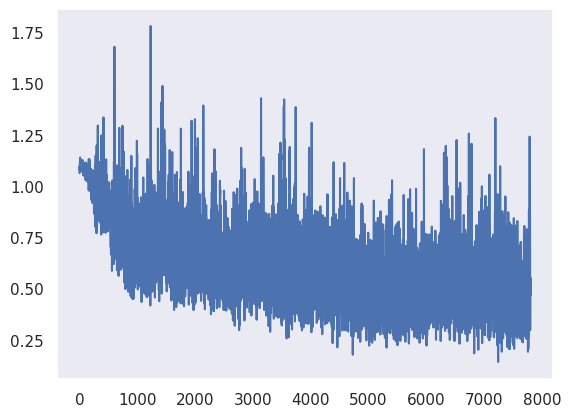

In [41]:
plt.plot(train_losses)

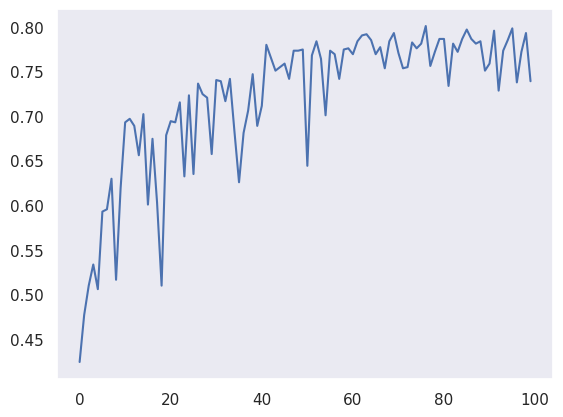

In [42]:
plt.plot(test_accuracy)

In [43]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 566/736 (0.7690)
{'acc_detail': tensor([0.9540, 0.7808, 0.5703], device='cuda:0'),
 'acc_unweighted': tensor(0.7684, device='cuda:0'),
 'acc_weighted': tensor(0.7690, device='cuda:0'),
 'f1s': tensor(0.7606, device='cuda:0'),
 'f1s_detail': tensor([0.8814, 0.6881, 0.7122], device='cuda:0'),
 'precision_detail': tensor([0.8191, 0.6151, 0.9481], device='cuda:0'),
 'recall_detail': tensor([0.9540, 0.7808, 0.5703], device='cuda:0'),
 'rocauc': tensor([0.9826, 0.8614, 0.9507], device='cuda:0'),
 'uar': tensor(0.7684, device='cuda:0'),
 'wap': tensor(0.8032, device='cuda:0')}


tensor([[249,  12,   0],
        [ 40, 171,   8],
        [ 15,  95, 146]], device='cuda:0')

In [44]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [45]:
best_epoch = 77
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 608/736 (0.8261)
{'acc_detail': tensor([0.9228, 0.8018, 0.7490], device='cuda:0'),
 'acc_unweighted': tensor(0.8245, device='cuda:0'),
 'acc_weighted': tensor(0.8261, device='cuda:0'),
 'f1s': tensor(0.8234, device='cuda:0'),
 'f1s_detail': tensor([0.9192, 0.7432, 0.8076], device='cuda:0'),
 'precision_detail': tensor([0.9157, 0.6926, 0.8761], device='cuda:0'),
 'recall_detail': tensor([0.9228, 0.8018, 0.7490], device='cuda:0'),
 'rocauc': tensor([0.9818, 0.9020, 0.9423], device='cuda:0'),
 'uar': tensor(0.8245, device='cuda:0'),
 'wap': tensor(0.8347, device='cuda:0')}


tensor([[239,  20,   0],
        [ 17, 178,  27],
        [  5,  59, 191]], device='cuda:0')

In [46]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [47]:
np.save('../cremad3_m12new_trill19_100epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_m12new_trill19_100epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [48]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+100, n_epoch4+100 + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.019801980198019802/50 [00:00<16:21, 19.63s/it]

Train Epoch: 101 [0/2508 (0%)]	Loss: 0.416886
Mem before-during-after: 23301120 518975488 24311808


  1%|█▍                                                                                                                                                                             | 0.41584158415841604/50 [00:08<16:14, 19.65s/it]

Train Epoch: 101 [1280/2508 (51%)]	Loss: 0.364830
Mem before-during-after: 24311808 520551936 24311808


  2%|███▌                                                                                                                                                                            | 1.0099009900990106/50 [00:19<15:34, 19.07s/it]


Test Epoch: 101	Accuracy: 596/736 (79%)

Train Epoch: 102 [0/2508 (0%)]	Loss: 0.515435
Mem before-during-after: 24307712 520027648 24311808


  3%|████▉                                                                                                                                                                           | 1.4158415841584169/50 [00:28<16:03, 19.83s/it]

Train Epoch: 102 [1280/2508 (51%)]	Loss: 0.399012
Mem before-during-after: 24311808 520551936 24311808


  4%|███████                                                                                                                                                                         | 2.0099009900990112/50 [00:39<15:14, 19.05s/it]


Test Epoch: 102	Accuracy: 600/736 (79%)

Train Epoch: 103 [0/2508 (0%)]	Loss: 0.418832
Mem before-during-after: 24307712 520027648 24311808


  5%|████████▌                                                                                                                                                                       | 2.4158415841584175/50 [00:47<15:40, 19.76s/it]

Train Epoch: 103 [1280/2508 (51%)]	Loss: 0.423091
Mem before-during-after: 24311808 520551936 24311808


  6%|██████████▌                                                                                                                                                                      | 3.000000000000002/50 [00:59<14:37, 18.67s/it]


Test Epoch: 103	Accuracy: 598/736 (79%)



  6%|██████████▋                                                                                                                                                                      | 3.019801980198022/50 [00:59<15:07, 19.32s/it]

Train Epoch: 104 [0/2508 (0%)]	Loss: 0.573996
Mem before-during-after: 24307712 520027648 24311808


  7%|████████████                                                                                                                                                                    | 3.4158415841584184/50 [01:07<15:28, 19.93s/it]

Train Epoch: 104 [1280/2508 (51%)]	Loss: 0.514980
Mem before-during-after: 24311808 520551936 24311808


  8%|██████████████▏                                                                                                                                                                  | 4.009900990099013/50 [01:19<14:38, 19.09s/it]


Test Epoch: 104	Accuracy: 609/736 (80%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_104epoch.pt
Train Epoch: 105 [0/2508 (0%)]	Loss: 0.270500
Mem before-during-after: 24307712 520027648 24311808


  9%|███████████████▋                                                                                                                                                                 | 4.415841584158419/50 [01:27<15:04, 19.85s/it]

Train Epoch: 105 [1280/2508 (51%)]	Loss: 0.380614
Mem before-during-after: 24311808 520551936 24311808


 10%|█████████████████▋                                                                                                                                                              | 5.0099009900990135/50 [01:38<14:10, 18.90s/it]


Test Epoch: 105	Accuracy: 596/736 (79%)

Train Epoch: 106 [0/2508 (0%)]	Loss: 0.326053
Mem before-during-after: 24307712 520027648 24311808


 11%|███████████████████▏                                                                                                                                                              | 5.40594059405941/50 [01:46<15:05, 20.30s/it]

Train Epoch: 106 [1280/2508 (51%)]	Loss: 0.397658
Mem before-during-after: 24311808 520551936 24311808


 12%|█████████████████████▏                                                                                                                                                           | 6.000000000000004/50 [01:58<13:48, 18.83s/it]


Test Epoch: 106	Accuracy: 610/736 (80%)

saved model: ../models_cremad3_trill19/cremad_label3_trill19_m12new_best_106epoch.pt


 12%|█████████████████████▎                                                                                                                                                           | 6.019801980198024/50 [01:58<14:11, 19.37s/it]

Train Epoch: 107 [0/2508 (0%)]	Loss: 0.324171
Mem before-during-after: 24307712 520027648 24311808


 13%|██████████████████████▋                                                                                                                                                          | 6.415841584158421/50 [02:06<14:21, 19.76s/it]

Train Epoch: 107 [1280/2508 (51%)]	Loss: 0.429710
Mem before-during-after: 24311808 520551936 24311808


 14%|████████████████████████▊                                                                                                                                                        | 7.009900990099015/50 [02:18<13:47, 19.26s/it]


Test Epoch: 107	Accuracy: 603/736 (79%)

Train Epoch: 108 [0/2508 (0%)]	Loss: 0.237592
Mem before-during-after: 24307712 520027648 24311808


 15%|██████████████████████████                                                                                                                                                      | 7.4158415841584215/50 [02:26<13:59, 19.70s/it]

Train Epoch: 108 [1280/2508 (51%)]	Loss: 0.475274
Mem before-during-after: 24311808 520551936 24311808


 16%|████████████████████████████▎                                                                                                                                                    | 8.009900990099014/50 [02:37<13:15, 18.95s/it]


Test Epoch: 108	Accuracy: 599/736 (79%)

Train Epoch: 109 [0/2508 (0%)]	Loss: 0.500363
Mem before-during-after: 24307712 520027648 24311808


 17%|█████████████████████████████▊                                                                                                                                                   | 8.415841584158384/50 [02:45<13:36, 19.65s/it]

Train Epoch: 109 [1280/2508 (51%)]	Loss: 0.516140
Mem before-during-after: 24311808 520551936 24311808


 18%|███████████████████████████████▉                                                                                                                                                 | 9.009900990098926/50 [02:57<12:56, 18.94s/it]


Test Epoch: 109	Accuracy: 598/736 (79%)

Train Epoch: 110 [0/2508 (0%)]	Loss: 0.481605
Mem before-during-after: 24307712 520027648 24311808


 19%|█████████████████████████████████▎                                                                                                                                               | 9.415841584158295/50 [03:05<13:19, 19.69s/it]

Train Epoch: 110 [1280/2508 (51%)]	Loss: 0.405477
Mem before-during-after: 24311808 520551936 24311808


 20%|███████████████████████████████████▏                                                                                                                                            | 10.009900990098837/50 [03:16<12:38, 18.96s/it]


Test Epoch: 110	Accuracy: 588/736 (77%)

Train Epoch: 111 [0/2508 (0%)]	Loss: 0.486799
Mem before-during-after: 24307712 520027648 24311808


 21%|████████████████████████████████████▋                                                                                                                                           | 10.415841584158207/50 [03:24<13:09, 19.95s/it]

Train Epoch: 111 [1280/2508 (51%)]	Loss: 0.450830
Mem before-during-after: 24311808 520551936 24311808


 22%|██████████████████████████████████████▊                                                                                                                                         | 11.009900990098748/50 [03:36<12:29, 19.22s/it]


Test Epoch: 111	Accuracy: 585/736 (77%)

Train Epoch: 112 [0/2508 (0%)]	Loss: 0.360244
Mem before-during-after: 24307712 520027648 24311808


 23%|████████████████████████████████████████▏                                                                                                                                       | 11.405940594059109/50 [03:44<13:05, 20.35s/it]

Train Epoch: 112 [1280/2508 (51%)]	Loss: 0.215535
Mem before-during-after: 24311808 520551936 24311808


 24%|██████████████████████████████████████████▎                                                                                                                                     | 12.009900990098659/50 [03:56<12:02, 19.01s/it]


Test Epoch: 112	Accuracy: 594/736 (78%)

Train Epoch: 113 [0/2508 (0%)]	Loss: 0.365592
Mem before-during-after: 24307712 520027648 24311808


 25%|███████████████████████████████████████████▋                                                                                                                                    | 12.415841584158029/50 [04:04<12:20, 19.71s/it]

Train Epoch: 113 [1280/2508 (51%)]	Loss: 0.363485
Mem before-during-after: 24311808 520551936 24311808


 26%|██████████████████████████████████████████████                                                                                                                                   | 13.00990099009857/50 [04:15<11:39, 18.92s/it]


Test Epoch: 113	Accuracy: 606/736 (80%)

Train Epoch: 114 [0/2508 (0%)]	Loss: 0.618628
Mem before-during-after: 24307712 520027648 24311808


 27%|███████████████████████████████████████████████▍                                                                                                                                 | 13.41584158415794/50 [04:23<12:15, 20.11s/it]

Train Epoch: 114 [1280/2508 (51%)]	Loss: 0.535517
Mem before-during-after: 24311808 520551936 24311808


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 14.009900990098481/50 [04:35<11:31, 19.22s/it]


Test Epoch: 114	Accuracy: 595/736 (78%)

Train Epoch: 115 [0/2508 (0%)]	Loss: 0.315615
Mem before-during-after: 24307712 520027648 24311808


 29%|██████████████████████████████████████████████████▋                                                                                                                             | 14.415841584157851/50 [04:43<11:46, 19.86s/it]

Train Epoch: 115 [1280/2508 (51%)]	Loss: 0.422133
Mem before-during-after: 24311808 520551936 24311808


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 15.009900990098393/50 [04:54<11:02, 18.94s/it]


Test Epoch: 115	Accuracy: 598/736 (79%)

Train Epoch: 116 [0/2508 (0%)]	Loss: 0.419538
Mem before-during-after: 24307712 520027648 24311808


 31%|██████████████████████████████████████████████████████▎                                                                                                                         | 15.415841584157763/50 [05:03<11:33, 20.06s/it]

Train Epoch: 116 [1280/2508 (51%)]	Loss: 0.274104
Mem before-during-after: 24311808 520551936 24311808


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 16.009900990098306/50 [05:14<10:45, 18.98s/it]


Test Epoch: 116	Accuracy: 590/736 (78%)

Train Epoch: 117 [0/2508 (0%)]	Loss: 0.510815
Mem before-during-after: 24307712 520027648 24311808


 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 16.415841584157675/50 [05:22<11:10, 19.98s/it]

Train Epoch: 117 [1280/2508 (51%)]	Loss: 0.313078
Mem before-during-after: 24311808 520551936 24311808


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 17.009900990098217/50 [05:34<10:25, 18.96s/it]


Test Epoch: 117	Accuracy: 592/736 (78%)

Train Epoch: 118 [0/2508 (0%)]	Loss: 0.432480
Mem before-during-after: 24307712 520027648 24311808


 35%|█████████████████████████████████████████████████████████████▎                                                                                                                  | 17.415841584157587/50 [05:42<10:39, 19.62s/it]

Train Epoch: 118 [1280/2508 (51%)]	Loss: 0.211696
Mem before-during-after: 24311808 520551936 24311808


 36%|███████████████████████████████████████████████████████████████▍                                                                                                                | 18.009900990098128/50 [05:53<10:01, 18.82s/it]


Test Epoch: 118	Accuracy: 588/736 (77%)

Train Epoch: 119 [0/2508 (0%)]	Loss: 0.430588
Mem before-during-after: 24307712 520027648 24311808


 37%|████████████████████████████████████████████████████████████████▊                                                                                                               | 18.415841584157498/50 [06:01<10:21, 19.67s/it]

Train Epoch: 119 [1280/2508 (51%)]	Loss: 0.564377
Mem before-during-after: 24311808 520551936 24311808


 38%|███████████████████████████████████████████████████████████████████▎                                                                                                             | 19.00990099009804/50 [06:13<09:46, 18.93s/it]


Test Epoch: 119	Accuracy: 581/736 (77%)

Train Epoch: 120 [0/2508 (0%)]	Loss: 0.567654
Mem before-during-after: 24307712 520027648 24311808


 39%|████████████████████████████████████████████████████████████████████▋                                                                                                            | 19.41584158415741/50 [06:21<10:13, 20.06s/it]

Train Epoch: 120 [1280/2508 (51%)]	Loss: 0.409688
Mem before-during-after: 24311808 520551936 24311808


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 19.99999999999894/50 [06:32<09:49, 19.66s/it]


Test Epoch: 120	Accuracy: 582/736 (77%)



 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 20.01980198019696/50 [06:33<10:19, 20.65s/it]

Train Epoch: 121 [0/2508 (0%)]	Loss: 0.314874
Mem before-during-after: 24307712 520027648 24311808


 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                        | 20.41584158415732/50 [06:41<10:03, 20.41s/it]

Train Epoch: 121 [1280/2508 (51%)]	Loss: 0.494715
Mem before-during-after: 24311808 520551936 24311808


 42%|██████████████████████████████████████████████████████████████████████████▍                                                                                                      | 21.00990099009786/50 [06:53<09:23, 19.43s/it]


Test Epoch: 121	Accuracy: 595/736 (78%)

Train Epoch: 122 [0/2508 (0%)]	Loss: 0.420573
Mem before-during-after: 24307712 520027648 24311808


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                     | 21.41584158415723/50 [07:01<09:41, 20.33s/it]

Train Epoch: 122 [1280/2508 (51%)]	Loss: 0.247396
Mem before-during-after: 24311808 520551936 24311808


 44%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 22.009900990097773/50 [07:13<08:46, 18.82s/it]


Test Epoch: 122	Accuracy: 596/736 (79%)

Train Epoch: 123 [0/2508 (0%)]	Loss: 0.280829
Mem before-during-after: 24307712 520027648 24311808


 45%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 22.415841584157143/50 [07:21<08:59, 19.55s/it]

Train Epoch: 123 [1280/2508 (51%)]	Loss: 0.541245
Mem before-during-after: 24311808 520551936 24311808


 46%|████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 23.009900990097684/50 [07:32<08:40, 19.29s/it]


Test Epoch: 123	Accuracy: 604/736 (80%)

Train Epoch: 124 [0/2508 (0%)]	Loss: 0.345267
Mem before-during-after: 24307712 520027648 24311808


 47%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 23.415841584157054/50 [07:41<08:52, 20.03s/it]

Train Epoch: 124 [1280/2508 (51%)]	Loss: 0.358366
Mem before-during-after: 24311808 520551936 24311808


 48%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 24.009900990097595/50 [07:52<08:22, 19.32s/it]


Test Epoch: 124	Accuracy: 569/736 (75%)

Train Epoch: 125 [0/2508 (0%)]	Loss: 0.449319
Mem before-during-after: 24307712 520027648 24311808


 49%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 24.415841584156965/50 [08:01<08:33, 20.06s/it]

Train Epoch: 125 [1280/2508 (51%)]	Loss: 0.322300
Mem before-during-after: 24311808 520551936 24311808


 50%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 24.999999999998497/50 [08:12<07:58, 19.16s/it]


Test Epoch: 125	Accuracy: 599/736 (79%)



 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 25.009900990097506/50 [08:12<08:17, 19.90s/it]

Train Epoch: 126 [0/2508 (0%)]	Loss: 0.419784
Mem before-during-after: 24307712 520027648 24311808


 51%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 25.415841584156876/50 [08:20<08:07, 19.81s/it]

Train Epoch: 126 [1280/2508 (51%)]	Loss: 0.251219
Mem before-during-after: 24311808 520551936 24311808


 52%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 25.99999999999841/50 [08:32<07:45, 19.41s/it]


Test Epoch: 126	Accuracy: 598/736 (79%)



 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 26.019801980196426/50 [08:32<07:46, 19.47s/it]

Train Epoch: 127 [0/2508 (0%)]	Loss: 0.347024
Mem before-during-after: 24307712 520027648 24311808


 53%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 26.415841584156787/50 [08:40<07:54, 20.10s/it]

Train Epoch: 127 [1280/2508 (51%)]	Loss: 1.007515
Mem before-during-after: 24311808 520551936 24311808


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 27.00990099009733/50 [08:52<07:20, 19.16s/it]


Test Epoch: 127	Accuracy: 601/736 (79%)

Train Epoch: 128 [0/2508 (0%)]	Loss: 0.497324
Mem before-during-after: 24307712 520027648 24311808


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 27.4158415841567/50 [09:00<07:23, 19.65s/it]

Train Epoch: 128 [1280/2508 (51%)]	Loss: 0.553852
Mem before-during-after: 24311808 520551936 24311808


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 28.00990099009724/50 [09:12<06:57, 18.98s/it]


Test Epoch: 128	Accuracy: 590/736 (78%)

Train Epoch: 129 [0/2508 (0%)]	Loss: 0.536691
Mem before-during-after: 24307712 520027648 24311808


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 28.41584158415661/50 [09:20<07:05, 19.71s/it]

Train Epoch: 129 [1280/2508 (51%)]	Loss: 0.331466
Mem before-during-after: 24311808 520551936 24311808


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 29.00990099009715/50 [09:31<06:48, 19.45s/it]


Test Epoch: 129	Accuracy: 602/736 (79%)

Train Epoch: 130 [0/2508 (0%)]	Loss: 0.219004
Mem before-during-after: 24307712 520027648 24311808


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 29.41584158415652/50 [09:40<06:50, 19.95s/it]

Train Epoch: 130 [1280/2508 (51%)]	Loss: 0.793256
Mem before-during-after: 24311808 520551936 24311808


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 30.009900990097062/50 [09:51<06:18, 18.92s/it]


Test Epoch: 130	Accuracy: 591/736 (78%)

Train Epoch: 131 [0/2508 (0%)]	Loss: 0.310302
Mem before-during-after: 24307712 520027648 24311808


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 30.415841584156432/50 [09:59<06:28, 19.82s/it]

Train Epoch: 131 [1280/2508 (51%)]	Loss: 0.317900
Mem before-during-after: 24311808 520551936 24311808


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 30.999999999997964/50 [10:11<05:57, 18.81s/it]


Test Epoch: 131	Accuracy: 598/736 (79%)



 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 31.019801980195982/50 [10:11<06:03, 19.13s/it]

Train Epoch: 132 [0/2508 (0%)]	Loss: 0.222229
Mem before-during-after: 24307712 520027648 24311808


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 31.415841584156343/50 [10:19<06:10, 19.92s/it]

Train Epoch: 132 [1280/2508 (51%)]	Loss: 0.639071
Mem before-during-after: 24311808 520551936 24311808


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 32.00990099009689/50 [10:31<05:40, 18.91s/it]


Test Epoch: 132	Accuracy: 591/736 (78%)

Train Epoch: 133 [0/2508 (0%)]	Loss: 0.295111
Mem before-during-after: 24307712 520027648 24311808


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 32.415841584156404/50 [10:39<05:43, 19.56s/it]

Train Epoch: 133 [1280/2508 (51%)]	Loss: 0.287721
Mem before-during-after: 24311808 520551936 24311808


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 32.999999999998145/50 [10:50<05:18, 18.76s/it]


Test Epoch: 133	Accuracy: 593/736 (78%)



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 33.01980198019617/50 [10:50<05:29, 19.39s/it]

Train Epoch: 134 [0/2508 (0%)]	Loss: 0.370422
Mem before-during-after: 24307712 520027648 24311808


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 33.415841584156674/50 [10:58<05:22, 19.47s/it]

Train Epoch: 134 [1280/2508 (51%)]	Loss: 0.578172
Mem before-during-after: 24311808 520551936 24311808


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 34.00990099009743/50 [11:10<05:10, 19.43s/it]


Test Epoch: 134	Accuracy: 598/736 (79%)

Train Epoch: 135 [0/2508 (0%)]	Loss: 0.341469
Mem before-during-after: 24307712 520027648 24311808


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 34.415841584156944/50 [11:18<05:14, 20.15s/it]

Train Epoch: 135 [1280/2508 (51%)]	Loss: 0.404319
Mem before-during-after: 24311808 520551936 24311808


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 35.0099009900977/50 [11:30<04:46, 19.09s/it]


Test Epoch: 135	Accuracy: 591/736 (78%)

Train Epoch: 136 [0/2508 (0%)]	Loss: 0.388206
Mem before-during-after: 24307712 520027648 24311808


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 35.415841584157214/50 [11:38<04:49, 19.85s/it]

Train Epoch: 136 [1280/2508 (51%)]	Loss: 0.162715
Mem before-during-after: 24311808 520551936 24311808


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 35.999999999998956/50 [11:49<04:26, 19.01s/it]


Test Epoch: 136	Accuracy: 587/736 (77%)



 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 36.01980198019698/50 [11:50<04:32, 19.52s/it]

Train Epoch: 137 [0/2508 (0%)]	Loss: 0.287493
Mem before-during-after: 24307712 520027648 24311808


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 36.415841584157484/50 [11:58<04:34, 20.23s/it]

Train Epoch: 137 [1280/2508 (51%)]	Loss: 0.267713
Mem before-during-after: 24311808 520551936 24311808


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 36.999999999999226/50 [12:10<04:06, 18.95s/it]


Test Epoch: 137	Accuracy: 603/736 (79%)

Train Epoch: 138 [0/2508 (0%)]	Loss: 0.187530
Mem before-during-after: 24307712 520027648 24311808


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 37.415841584157754/50 [12:18<04:17, 20.43s/it]

Train Epoch: 138 [1280/2508 (51%)]	Loss: 0.374375
Mem before-during-after: 24311808 520551936 24311808


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 38.00990099009851/50 [12:30<03:50, 19.21s/it]


Test Epoch: 138	Accuracy: 601/736 (79%)

Train Epoch: 139 [0/2508 (0%)]	Loss: 0.233272
Mem before-during-after: 24307712 520027648 24311808


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 38.415841584158024/50 [12:38<03:51, 19.97s/it]

Train Epoch: 139 [1280/2508 (51%)]	Loss: 0.469544
Mem before-during-after: 24311808 520551936 24311808


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 38.999999999999766/50 [12:49<03:22, 18.40s/it]


Test Epoch: 139	Accuracy: 584/736 (77%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 39.01980198019779/50 [12:50<03:28, 18.97s/it]

Train Epoch: 140 [0/2508 (0%)]	Loss: 0.279622
Mem before-during-after: 24307712 520027648 24311808


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 39.415841584158294/50 [12:57<03:28, 19.66s/it]

Train Epoch: 140 [1280/2508 (51%)]	Loss: 0.705372
Mem before-during-after: 24311808 520551936 24311808


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 40.00990099009905/50 [13:09<03:13, 19.34s/it]


Test Epoch: 140	Accuracy: 588/736 (77%)

Train Epoch: 141 [0/2508 (0%)]	Loss: 0.600754
Mem before-during-after: 24307712 520027648 24311808


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 40.415841584158564/50 [13:17<03:08, 19.65s/it]

Train Epoch: 141 [1280/2508 (51%)]	Loss: 0.329649
Mem before-during-after: 24311808 520551936 24311808


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 41.00990099009932/50 [13:28<02:50, 18.98s/it]


Test Epoch: 141	Accuracy: 604/736 (80%)

Train Epoch: 142 [0/2508 (0%)]	Loss: 0.443650
Mem before-during-after: 24307712 520027648 24311808


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 41.415841584158834/50 [13:37<02:53, 20.23s/it]

Train Epoch: 142 [1280/2508 (51%)]	Loss: 0.528378
Mem before-during-after: 24311808 520551936 24311808


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 42.00990099009959/50 [13:48<02:34, 19.29s/it]


Test Epoch: 142	Accuracy: 603/736 (79%)

Train Epoch: 143 [0/2508 (0%)]	Loss: 0.222485
Mem before-during-after: 24307712 520027648 24311808


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 42.415841584159104/50 [13:56<02:33, 20.28s/it]

Train Epoch: 143 [1280/2508 (51%)]	Loss: 0.284695
Mem before-during-after: 24311808 520551936 24311808


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 43.00990099009986/50 [14:08<02:14, 19.28s/it]


Test Epoch: 143	Accuracy: 595/736 (78%)

Train Epoch: 144 [0/2508 (0%)]	Loss: 0.463737
Mem before-during-after: 24307712 520027648 24311808


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 43.415841584159374/50 [14:16<02:11, 20.01s/it]

Train Epoch: 144 [1280/2508 (51%)]	Loss: 0.272420
Mem before-during-after: 24311808 520551936 24311808


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 44.00990099010013/50 [14:28<01:55, 19.21s/it]


Test Epoch: 144	Accuracy: 587/736 (77%)

Train Epoch: 145 [0/2508 (0%)]	Loss: 0.389554
Mem before-during-after: 24307712 520027648 24311808


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 44.40594059406063/50 [14:36<01:53, 20.33s/it]

Train Epoch: 145 [1280/2508 (51%)]	Loss: 0.560290
Mem before-during-after: 24311808 520551936 24311808


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 45.000000000001386/50 [14:47<01:35, 19.20s/it]


Test Epoch: 145	Accuracy: 593/736 (78%)

Train Epoch: 146 [0/2508 (0%)]	Loss: 0.290423
Mem before-during-after: 24307712 520027648 24311808


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 45.415841584159914/50 [14:56<01:30, 19.65s/it]

Train Epoch: 146 [1280/2508 (51%)]	Loss: 0.341903
Mem before-during-after: 24311808 520551936 24311808


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 46.00990099010067/50 [15:07<01:15, 19.00s/it]


Test Epoch: 146	Accuracy: 600/736 (79%)

Train Epoch: 147 [0/2508 (0%)]	Loss: 0.468409
Mem before-during-after: 24307712 520027648 24311808


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 46.415841584160184/50 [15:15<01:10, 19.66s/it]

Train Epoch: 147 [1280/2508 (51%)]	Loss: 0.238129
Mem before-during-after: 24311808 520551936 24311808


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 47.00990099010094/50 [15:27<00:57, 19.13s/it]


Test Epoch: 147	Accuracy: 594/736 (78%)

Train Epoch: 148 [0/2508 (0%)]	Loss: 0.399586
Mem before-during-after: 24307712 520027648 24311808


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 47.415841584160454/50 [15:35<00:51, 19.74s/it]

Train Epoch: 148 [1280/2508 (51%)]	Loss: 0.404728
Mem before-during-after: 24311808 520551936 24311808


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 48.00990099010121/50 [15:46<00:37, 19.05s/it]


Test Epoch: 148	Accuracy: 570/736 (75%)

Train Epoch: 149 [0/2508 (0%)]	Loss: 0.272227
Mem before-during-after: 24307712 520027648 24311808


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 48.415841584160724/50 [15:54<00:31, 19.85s/it]

Train Epoch: 149 [1280/2508 (51%)]	Loss: 0.338369
Mem before-during-after: 24311808 520551936 24311808


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 49.00990099010148/50 [16:06<00:18, 19.03s/it]


Test Epoch: 149	Accuracy: 600/736 (79%)

Train Epoch: 150 [0/2508 (0%)]	Loss: 0.176777
Mem before-during-after: 24307712 520027648 24311808


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49.415841584160994/50 [16:14<00:11, 19.61s/it]

Train Epoch: 150 [1280/2508 (51%)]	Loss: 0.209378
Mem before-during-after: 24311808 520551936 24311808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.000000000002736/50 [16:25<00:00, 19.71s/it]


Test Epoch: 150	Accuracy: 599/736 (79%)



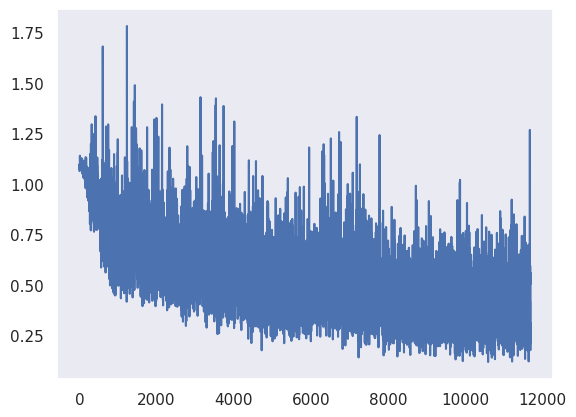

In [49]:
plt.plot(train_losses)

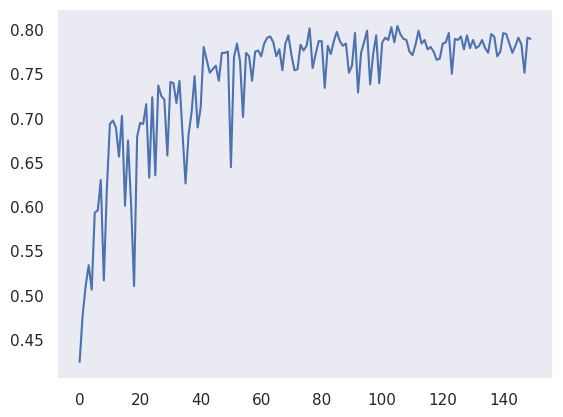

In [50]:
plt.plot(test_accuracy)

In [51]:
metrics4, confusion_matrix4 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics4.compute())
confusion_matrix4.compute()

Correct: 598/736 (0.8125)
{'acc_detail': tensor([0.9225, 0.6773, 0.8178], device='cuda:0'),
 'acc_unweighted': tensor(0.8059, device='cuda:0'),
 'acc_weighted': tensor(0.8125, device='cuda:0'),
 'f1s': tensor(0.8054, device='cuda:0'),
 'f1s_detail': tensor([0.9084, 0.6930, 0.8147], device='cuda:0'),
 'precision_detail': tensor([0.8947, 0.7095, 0.8115], device='cuda:0'),
 'recall_detail': tensor([0.9225, 0.6773, 0.8178], device='cuda:0'),
 'rocauc': tensor([0.9784, 0.8926, 0.9416], device='cuda:0'),
 'uar': tensor(0.8059, device='cuda:0'),
 'wap': tensor(0.8102, device='cuda:0')}


tensor([[238,  20,   0],
        [ 22, 149,  49],
        [  6,  41, 211]], device='cuda:0')

In [52]:
np.save('../cremad3_trill19_m12new_150epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../cremad3_trill19_m12new_150epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [53]:
model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [54]:
best_epoch = 106
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
pprint(metrics_best.compute())
confusion_matrix_best.compute()

Correct: 606/736 (0.8234)
{'acc_detail': tensor([0.9421, 0.7318, 0.7821], device='cuda:0'),
 'acc_unweighted': tensor(0.8187, device='cuda:0'),
 'acc_weighted': tensor(0.8234, device='cuda:0'),
 'f1s': tensor(0.8176, device='cuda:0'),
 'f1s_detail': tensor([0.9088, 0.7302, 0.8138], device='cuda:0'),
 'precision_detail': tensor([0.8777, 0.7285, 0.8481], device='cuda:0'),
 'recall_detail': tensor([0.9421, 0.7318, 0.7821], device='cuda:0'),
 'rocauc': tensor([0.9812, 0.9009, 0.9431], device='cuda:0'),
 'uar': tensor(0.8187, device='cuda:0'),
 'wap': tensor(0.8228, device='cuda:0')}


tensor([[244,  15,   0],
        [ 23, 161,  36],
        [ 11,  45, 201]], device='cuda:0')

In [58]:
best_model.to('cpu')

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [55]:
best_accuracy

0.8036890645586298

In [56]:
model_path = '../models_cremad3_trill19/cremad_label3_trill19_m12new_150epochs.pt' 
torch.save(model.state_dict(), model_path)